# Metaheurística e quantidade de conhecimento a priori utilizado para gerar a população inicia

Neste notebook apresentamos a comparação do nível de conhecimento *a priori* necessário para os seguintes algoritmos de busca e otimização:
- **RW**: Randon Walk
- **MC**: Método de Monte Carlo
- **MCTS**: Tree Search com método Monte Carlo
- **SA**: Simulated Annealing
- **GA**: Genetic Algorithm (usando DEAP)
- **DE**: Differential Evolution (usando SciPy)

## Função Trap

In [1]:
import numpy as np

def trap_k(u: int, k: int) -> int:
    """
    Função trap de ordem k aplicada ao número de uns 'u' em um bloco.
    """
    return k if u == k else k - 1 - u

def f_k(x: np.ndarray, k: int) -> int:
    """
    Avalia f_k em um vetor binário x de tamanho n, onde n % k == 0.
    """
    n = x.size
    m = n // k
    total = 0
    for i in range(m):
        # soma de uns no bloco i
        u = x[i*k : (i+1)*k].sum()
        total += trap_k(int(u), k)
    return total

## Funções de geração de sequências pseudo-aleatórias

In [2]:
import numpy as np

def fill_ones_up_to(x: np.ndarray, level: int):
    pos = max(0, min(level, len(x) - 1))
    x[:pos] = 1
    
def generate_item(chromo_size: int, p: int = 0)->np.ndarray:
    x = np.random.randint(0, 2, size=chromo_size)
    fill_ones_up_to(x, p)
    return x

def generate_list(chromo_size: int, pop_size: int, p: int = 0)->list[np.ndarray]:
    result: list[np.ndarray] = []
    for _ in range(pop_size):
        x = generate_item(chromo_size, p)
        result.append(x)
    return result
    

In [3]:
K=4
M=6
N=K*M
for p in range(0, M):
    print(f"g[{p}]={generate_item(N, p*K)}")

g[0]=[1 1 1 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 0 1 0]
g[1]=[1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1 1]
g[2]=[1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0]
g[3]=[1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1]
g[4]=[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0]
g[5]=[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0]


# Metaheurísticas

## Randon Walking

In [5]:
import matplotlib.pyplot as plt
import time

def random_search(n: int, k: int, 
    priori_level = 0,
    iterations = 10000, 
    seed: int = None
    )-> tuple[np.ndarray, int, list[int]]:
    
    if seed is not None:
        np.random.seed(seed)

    p = k * priori_level
        
    # solução inicial
    x = generate_item(n, p)
    
    best_value = f_k(x, k)
    best_x = x.copy()
    history = [best_value]
    
    for _ in range(1, iterations + 1):
        # escolhe índice para flip
        i = np.random.randint(p, n)
        x[i] ^= 1  # flip bit
        
        value = f_k(x, k)

        # atualiza melhor se necessário
        if value > best_value:
            best_value = value
            best_x = x.copy()

        history.append(best_value)

    return best_x, best_value, history

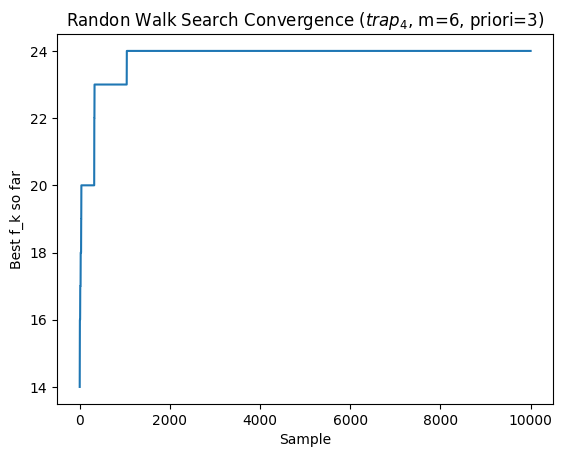

Best Value: 24
Best Solution: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Runtime: 0.611370 s


In [7]:
# Parameters
K=4
M=6
N=K*M
PRIORI = 3

# Running
start = time.perf_counter()
best_solution, best_score, hist = random_search(N, K, priori_level=PRIORI, seed=42)
end = time.perf_counter()

# Plot convergence
plt.figure()
plt.plot(hist)
plt.xlabel("Sample")
plt.ylabel("Best f_k so far")
plt.title(f"Randon Walk Search Convergence ($trap_{K}$, m={M}, priori={PRIORI})")
plt.show()

# Print results
print(f"Best Value: {best_score}")
print(f"Best Solution: {best_solution}")
print(f"Runtime: {end - start:.6f} s")

## Simulated Annealing

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def simulated_annealing(n: int, k: int, 
        priori_level = 0,
        initial_temp = 10.0,
        final_temp = 0.1,
        alpha = 0.95,
        num_iterations = 200,
        seed=None)-> tuple[np.ndarray, int, list[int]]:
    if seed is not None:
        np.random.seed(seed)
    
    p = k * priori_level
    
    x = generate_item(n, p)
    
    current_value = f_k(x, k)
    
    best_x = x.copy()
    best_value = current_value
    
    temp = initial_temp
    history = [best_value]
    
    while temp > final_temp:
        for _ in range(num_iterations):
            candidate = x.copy()
            idx = np.random.randint(p, n)
            candidate[idx] = 1 - candidate[idx]
            
            candidate_value = f_k(candidate, k)
            delta = candidate_value - current_value
            
            if delta > 0 or np.random.rand() < np.exp(delta / temp):
                x = candidate
                current_value = candidate_value
                if current_value > best_value:
                    best_value = current_value
                    best_x = x.copy()
            
            history.append(best_value)
        
        temp *= alpha
    
    return best_x, best_value, history

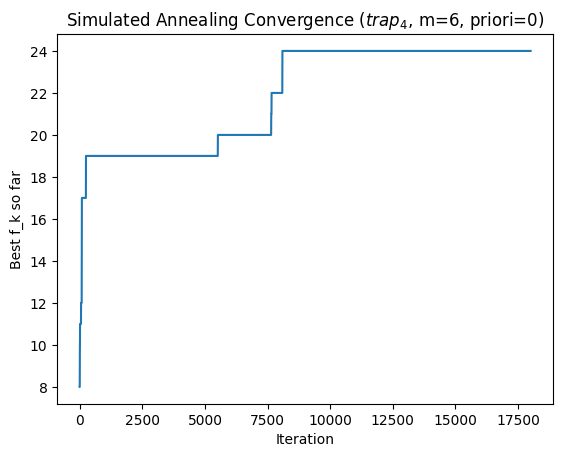

Best Value: 24
Best Solution: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Runtime: 0.911901 s


In [9]:
# Parameters
K=4
M=6
N=K*M
PRIORI = 0

# Running
start = time.perf_counter()
best_solution, best_score, hist = simulated_annealing(N, K, priori_level=PRIORI, seed=42)
end = time.perf_counter()

# Plot convergence
plt.figure()
plt.plot(hist)
plt.xlabel("Iteration")
plt.ylabel("Best f_k so far")
plt.title(f"Simulated Annealing Convergence ($trap_{K}$, m={M}, priori={PRIORI})")
plt.show()

# Print results
print(f"Best Value: {best_score}")
print(f"Best Solution: {best_solution}")
print(f"Runtime: {end - start:.6f} s")

## Método Monte Carlo

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def monte_carlo_search(n: int, k: int, 
    priori_level = 0,
    num_samples=10000, 
    seed=None
    )-> tuple[np.ndarray, int, list[int]]:
    if seed is not None:
        np.random.seed(seed)
    
    best_value = -np.inf
    best_x = None
    history = []
    
    p = k * priori_level
    
    for i in range(1, num_samples + 1):
        x = generate_item(n, p)
        value = f_k(x, k)
        if value > best_value:
            best_value = value
            best_x = x.copy()
        history.append(best_value)
    
    return best_x, best_value, history

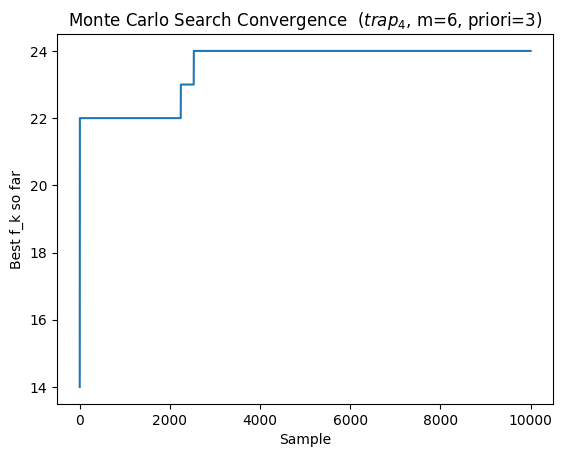

Best Value: 24
Best Solution: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Runtime: 0.656939 s


In [12]:
# Parameters
K=4
M=6
N=K*M
PRIORI = 3

# Running
start = time.perf_counter()
best_solution, best_score, hist = monte_carlo_search(N, K, priori_level=PRIORI, seed=42)
end = time.perf_counter()

# Plot convergence
plt.figure()
plt.plot(hist)
plt.xlabel("Sample")
plt.ylabel("Best f_k so far")
plt.title(f"Monte Carlo Search Convergence  ($trap_{K}$, m={M}, priori={PRIORI})")
plt.show()

# Print results
print(f"Best Value: {best_score}")
print(f"Best Solution: {best_solution}")
print(f"Runtime: {end - start:.6f} s")

## Monte Carlo Tree Search

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# MCTS ajustado para trap_k com retorno de histórico
class MCTSNode:
    def __init__(self, depth, parent=None):
        self.depth   = depth      # profundidade (quantos blocos já escolheram)
        self.parent  = parent     # nó pai (None no root)
        self.children= {}         # dicionário move → MCTSNode
        self.visits  = 0          # número de simulações que passaram por aqui
        self.value   = 0.0        # soma dos retornos acumulados
        self.choice  = None       # a ação (u em 0..k) que levou a este nó

    def is_fully_expanded(self, k):
        # retorna True se já criamos filhos para todas as k+1 escolhas possíveis
        return len(self.children) == (k + 1)

    def uct_score(self, total_simulations, c=1.0):
        # Upper-Confidence bound applied to Trees
        # Se ainda não foi visitado, força exploração
        if self.visits == 0:
            return np.inf
        # Exploração (value/visits) + Exploração (c * sqrt(log N_parent / visits))
        return (self.value / self.visits) + c * np.sqrt(np.log(total_simulations) / self.visits)

def rollout_reward(node, m, k, priori_level):
    total = 0
    cur = node
    # 1) retorno até a raiz: soma trap_k(choice, k) dos nós já escolhidos
    while cur.parent:
        total += trap_k(cur.choice, k)
        cur = cur.parent
    # 2) do nível atual até m: escolhas aleatórias
    for depth  in range(cur.depth, m):
        if depth < priori_level:
            u = k        # prioriza bloco completo de 1s
        else:
            u = np.random.randint(0, k+1)
        total += trap_k(u, k)
    return total

def monte_carlo_tree_search(n: int, k: int, 
    priori_level=0, 
    iterations=10000, 
    c=1.0, 
    seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    m = n // k
    
    root = MCTSNode(depth=0)
    total_sim = 0
    history = []
    best_value = -np.inf
    best_solution = None

    for _ in range(iterations):
        total_sim += 1
        node = root
        # seleção
        while node.depth < m and node.is_fully_expanded(k):
            scores = {u: child.uct_score(root.visits, c) for u, child in node.children.items()}
            choice = max(scores, key=scores.get)
            node = node.children[choice]
        # expansão
        if node.depth < m:
            untried = [u for u in range(k+1) if u not in node.children]
            if node.depth < priori_level:
                # força o filho “k” (todos 1s) como primeira expansão
                choice = k
            else:
                choice = np.random.choice(untried)
            child = MCTSNode(depth=node.depth+1, parent=node)
            child.choice = choice
            node.children[choice] = child
            node = child
            
        # simulação
        reward = rollout_reward(node, m, k, priori_level)
        
        # backpropagation
        cur = node
        while cur:
            cur.visits += 1
            cur.value += reward
            cur = cur.parent
            
        # constrói solução atual via melhor caminhos
        sol = []
        cur = root
        while cur.depth < m:
            if not cur.children:
                u = np.random.randint(0, k+1)
            else:
                u = max(cur.children, key=lambda x: cur.children[x].value / cur.children[x].visits)
            block = [1]*u + [0]*(k-u)
            np.random.shuffle(block)
            sol.extend(block)
            cur = cur.children.get(u, MCTSNode(depth=cur.depth+1))
        sol = np.array(sol)
        
        # avalia o vetor inteiro blocos-a-bloco
        score = sum(trap_k(int(sol[i:i+k].sum()), k) for i in range(0, n, k))
        
        # mantém o melhor global
        if score > best_value:
            best_value = score
            best_solution = sol.copy()
        history.append(best_value)

    return best_solution, best_value, history

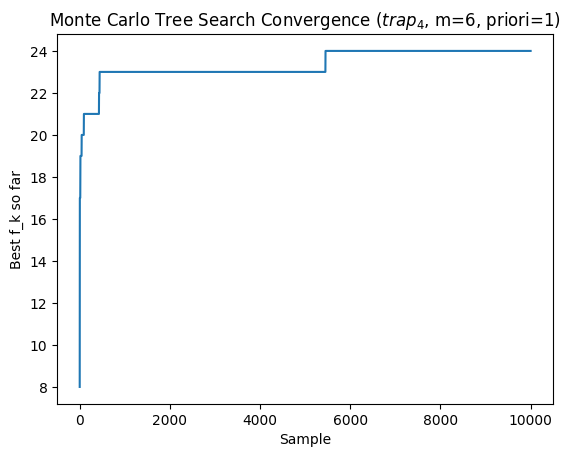

Best Value: 24
Best Solution: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Runtime: 1.626461 s


In [16]:
# Parameters
K=4
M=6
N=K*M
PRIORI = 1

# Running
start = time.perf_counter()
best_solution, best_score, hist = monte_carlo_tree_search(N, K, priori_level=PRIORI, seed=42)
end = time.perf_counter()

# Plot convergence
plt.figure()
plt.plot(hist)
plt.xlabel("Sample")
plt.ylabel("Best f_k so far")
plt.title(f"Monte Carlo Tree Search Convergence ($trap_{K}$, m={M}, priori={PRIORI})")
plt.show()

# Print results
print(f"Best Value: {best_score}")
print(f"Best Solution: {best_solution}")
print(f"Runtime: {end - start:.6f} s")

## Genetic Algorithm

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

def run_ga(n, k,
    priori_level=0,
    population_size = 200,
    num_generations = 50,
    cx_prob = 0.8,
    mut_prob = 0.1,
    seed = None):
    # Remove classes antigas caso existam
    if hasattr(creator, "FitnessMax"):
        delattr(creator, "FitnessMax")
    if hasattr(creator, "Individual"):
        delattr(creator, "Individual")
        
    # Configuração do DEAP
    if seed is not None:
        np.random.seed(seed)
        
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", np.random.randint, 0, 2)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n)
    
    toolbox.register("evaluate", lambda ind: (f_k(np.array(ind), k),))
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/n)
    toolbox.register("select", tools.selTournament, tournsize=4)

    # Customizado para aplicar níveis de conhecimento
    pop = [
        creator.Individual(
            generate_item(chromo_size=n, p=k*priori_level).tolist()
        )
        for _ in range(population_size)
    ]
    
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)

    # Executa AG
    pop, logbook = algorithms.eaSimple(pop, toolbox,
                                    cxpb=cx_prob, mutpb=mut_prob,
                                    ngen=num_generations,
                                    stats=stats, halloffame=hof,
                                    verbose=False)
    
    max_fit = logbook.select("max")
    
    best = np.argmax(ind.fitness.values[0] for ind in pop)
    best_fitness = max(ind.fitness.values[0] for ind in pop)
    
    return pop[best], best_fitness, max_fit

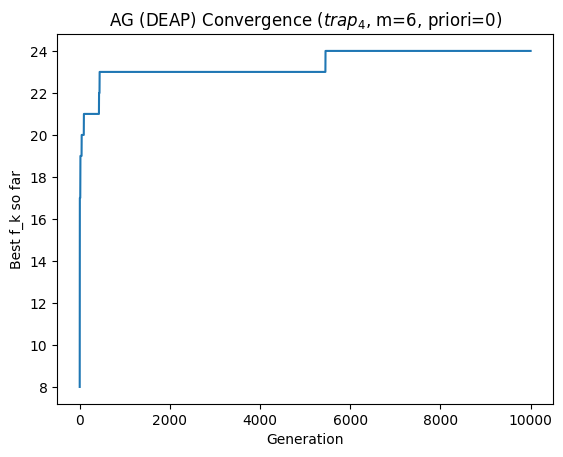

Best Value: 24.0
Best Solution: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Runtime: 1.009424 s


In [18]:
# Parameters
K=4
M=6
N=K*M
PRIORI = 0

# Running
start = time.perf_counter()
best_x, best_f, gens = run_ga(N, K, priori_level=PRIORI, seed=42)
end = time.perf_counter()

# Plot convergence
plt.figure()
plt.plot(hist)
plt.xlabel("Generation")
plt.ylabel("Best f_k so far")
plt.title(f"AG (DEAP) Convergence ($trap_{K}$, m={M}, priori={PRIORI})")
plt.show()

# Print results
print(f"Best Value: {best_f}")
print(f"Best Solution: {best_x}")
print(f"Runtime: {end - start:.6f} s")

## Differential Evolution

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

def generate_binary_pop(n: int, NP: int, p: int):
    """
    Gera NP indivíduos binários de tamanho n usando priori_level,
    e converte para reais em [0,1] para DE:
      - bits 1 → uniform(0.5,1)
      - bits 0 → uniform(0,0.5)
    """
    pop_real = np.zeros((NP, n))
    for i in range(NP):
        # cria binário com priorização de 1s
        x = generate_item(n, p)
        # mapeia para real
        pop_real[i] = np.where(x==1,
                               np.random.uniform(0.5, 1.0, size=n),
                               np.random.uniform(0.0, 0.5, size=n))
    return pop_real

def run_de(n: int, k: int,
           priori_level=0,
           strategy='rand1bin',
           maxiter=100,
           popsize=50,
           mutation=(0.1, 0.5),
           recombination=0.85,
           tol=0.01,
           seed=None,
          ) -> tuple[np.ndarray, float, list[float]]:

    def f_k_continuous(x, k):
        # converte real → binário e soma trap_k
        bin_x = (x >= 0.5).astype(int)
        total = 0
        m = len(bin_x) // k
        for i in range(m):
            u = bin_x[i*k:(i+1)*k].sum()
            total += trap_k(int(u), k)
        return -total  # DE minimiza

    if seed is not None:
        np.random.seed(seed)

    # Population size total para DE: NP = popsize * n
    NP = popsize * n
    # Gera população inicial com priori_level
    init_pop = generate_binary_pop(n, NP, k * priori_level)

    history: list[float] = []
    def record_best(xk, convergence):
        history.append(-f_k_continuous(xk, k))
        return False

    result = differential_evolution(
        func=lambda x: f_k_continuous(x, k),
        bounds=[(0,1)] * n,
        strategy=strategy,
        maxiter=maxiter,
        popsize=popsize,
        mutation=mutation,
        recombination=recombination,
        tol=tol,
        seed=seed,
        init=init_pop,
        callback=record_best,
        polish=True,             # refinamento final
        updating='deferred',     # velocidade em paralelo
        disp=False
    )

    best_real = result.x
    best_bin = (best_real >= 0.5).astype(int)
    best_score = -result.fun

    return best_bin, best_score, history

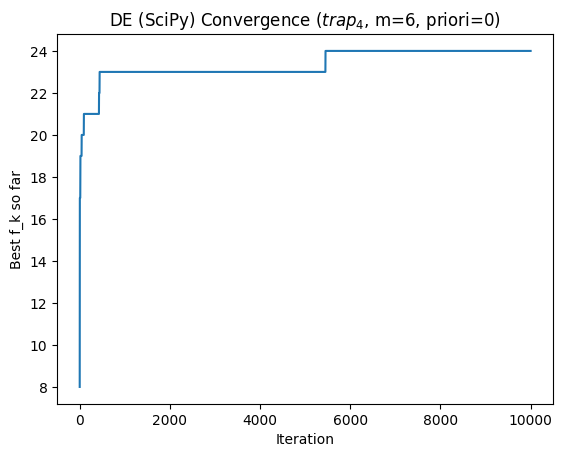

Best Value: 24.0
Best Solution: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Runtime: 22.571744 s


In [20]:
# Parameters
K=4
M=6
N=K*M
PRIORI = 0

# Running
start = time.perf_counter()
best_x, best_f, gens =  run_de(N, K, priori_level=PRIORI, seed=42)
end = time.perf_counter()

# Plot convergence
plt.figure()
plt.plot(hist)
plt.xlabel("Iteration")
plt.ylabel("Best f_k so far")
plt.title(f"DE (SciPy) Convergence ($trap_{K}$, m={M}, priori={PRIORI})")
plt.show()

# Print results
print(f"Best Value: {best_f}")
print(f"Best Solution: {best_x}")
print(f"Runtime: {end - start:.6f} s")

# Experimentos Comparativos

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def run_experiment(k: int, m: int, 
        n_trials: int = 10, 
        threshold: int = 9
        )->None:
    methods = {
        "RW": random_search,
        "MC": monte_carlo_search,
        "MCTS": monte_carlo_tree_search,
        "SA": simulated_annealing,
        "GA": run_ga,
        "DE": run_de
    }

    n_bits = k * m
    levels = [i for i in range(0, m)]

    # Experimento principal
    results = []
    for algo, func in methods.items():
        min_level = m
        for lvl in levels:
            succ = 0
            for _ in range(n_trials):
                x, fit, _ = func(n_bits, k, priori_level=lvl)
                print(f"{algo} lvl:{lvl} fit:{fit} x:{list(x)}")
                if fit == n_bits:
                    succ += 1
                if succ == threshold:
                    break
            if succ >= threshold:
                min_level = lvl
                break
        results.append({"Metaheurística": algo, "Nível conhecimento": min_level})

    df = pd.DataFrame(results)

    # Ordena do maior para o menor nível de conhecimento
    df_sorted = df.sort_values(by="Nível conhecimento", ascending=False)

    min_lvl = df_sorted["Nível conhecimento"].min()
    max_lvl = df_sorted["Nível conhecimento"].max()

    # Plotagem
    plt.figure(figsize=(8,6))
    sns.barplot(data=df_sorted, x="Metaheurística", y="Nível conhecimento")
    plt.ylim(min_lvl, max_lvl)
    plt.yticks(levels, labels=[str(l) for l in levels])
    plt.xlabel("Metaheurísticas")
    plt.ylabel("Nível mínimo de conhecimento prévio")
    plt.title(f"Conhecimento necessário para o sucesso em $trap_{k}$ m={m}")
    plt.show()

RW lvl:0 fit:19 x:[1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
RW lvl:0 fit:19 x:[1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
RW lvl:0 fit:18 x:[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1]
RW lvl:0 fit:18 x:[1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0]
RW lvl:0 fit:19 x:[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1]
RW lvl:0 fit:20 x:[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
RW lvl:0 fit:19 x:[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
RW lvl:0 fit:20 x:[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
RW lvl:0 fit:22 x:[1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
RW lvl:0 fit:21 x:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
RW lvl:1 fit:21 x:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0]

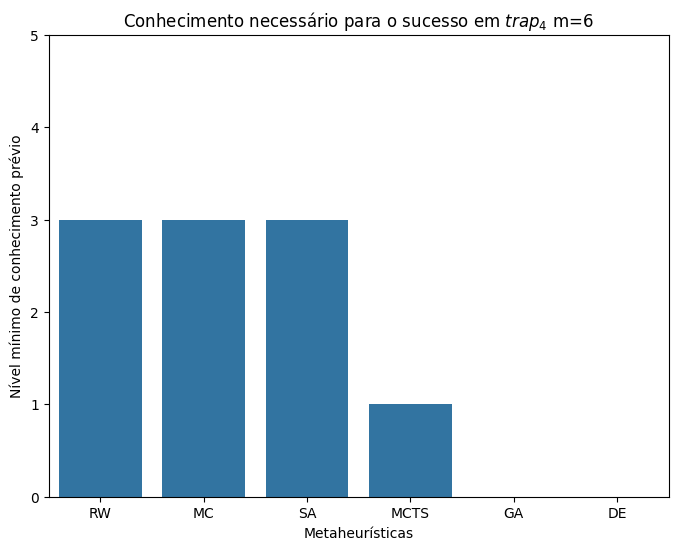

In [22]:
# K=4, M=6 => N=24
# Classificação com 90% de sucesso
run_experiment(k=4, m=6, n_trials=10, threshold=9)

RW lvl:0 fit:16 x:[1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]
RW lvl:0 fit:17 x:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1]
RW lvl:0 fit:16 x:[0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
RW lvl:0 fit:17 x:[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]
RW lvl:0 fit:16 x:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
RW lvl:0 fit:16 x:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
RW lvl:0 fit:16 x:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]
RW lvl:0 fit:15 x:[1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0]
RW lvl:0 fit:17 x:[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
RW lvl:0 fit:17 x:[1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
RW lvl:1 fit:18 x:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
RW lvl:1 fit:17 x:[1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
RW lvl:1 fit:17 x:[1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
RW lvl:1 fit:16 x:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

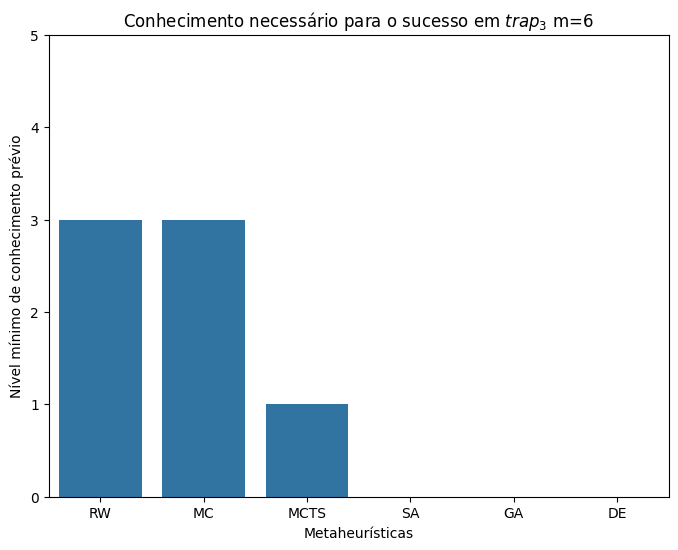

In [23]:
# K=3, M=6 => N=18
# Classificação com 90% de sucesso
run_experiment(k=3, m=6, n_trials=10, threshold=9)